In [1]:
import atlite
cutout = atlite.Cutout("/Users/simon/Documents/01_Uni/02_Master/S3/05 DSESM/4group assign/era5_aut_2019.nc")

In [2]:
cutout.data

<xarray.Dataset> Size: 249MB
Dimensions:               (y: 13, x: 32, time: 8784)
Coordinates:
  * y                     (y) float64 104B 46.25 46.5 46.75 ... 48.75 49.0 49.25
  * x                     (x) float64 256B 9.5 9.75 10.0 ... 16.75 17.0 17.25
  * time                  (time) datetime64[ns] 70kB 2019-01-01 ... 2020-01-0...
    lon                   (x) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    lat                   (y) float64 104B dask.array<chunksize=(13,), meta=np.ndarray>
Data variables: (12/15)
    height                (y, x) float32 2kB dask.array<chunksize=(13, 32), meta=np.ndarray>
    wnd100m               (time, y, x) float32 15MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    wnd_shear_exp         (time, y, x) float64 29MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    wnd_azimuth           (time, y, x) float32 15MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    roughness             (time, y, x) float32 15MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    influx_toa            (time, y, x) float32 15MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    ...                    ...
    solar_altitude        (time, y, x) float64 29MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    solar_azimuth         (time, y, x) float64 29MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    temperature           (time, y, x) float32 15MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    soil temperature      (time, y, x) float32 15MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    dewpoint temperature  (time, y, x) float32 15MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
    runoff                (time, y, x) float32 15MB dask.array<chunksize=(100, 13, 32), meta=np.ndarray>
Attributes:
    module:                  era5
    prepared_features:       ['temperature', 'height', 'runoff', 'influx', 'w...
    chunksize_time:          100
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-22T18:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
cutout.data.variables


Frozen({'height': <xarray.Variable (y: 13, x: 32)> Size: 2kB
dask.array<xarray-height, shape=(13, 32), dtype=float32, chunksize=(13, 32), chunktype=numpy.ndarray>
Attributes: (12/34)
    GRIB_paramId:                             129
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      416
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    long_name:                                Geopotential
    units:                                    m**2 s**-2
    standard_name:                            geopotential
    GRIB_surface:                             0.0
    module:                                   era5
    feature:                                  height, 'wnd100m': <xarray.Variable (time: 8784, y: 13, x: 32)> Size: 15MB
dask.array<xarray-wnd100m, shape=(8784, 13, 32), dtype=float32, c

In [4]:
cutout.coords


Coordinates:
  * y        (y) float64 104B 46.25 46.5 46.75 47.0 ... 48.5 48.75 49.0 49.25
  * x        (x) float64 256B 9.5 9.75 10.0 10.25 10.5 ... 16.5 16.75 17.0 17.25
  * time     (time) datetime64[ns] 70kB 2019-01-01 ... 2020-01-01T23:00:00
    lon      (x) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    lat      (y) float64 104B dask.array<chunksize=(13,), meta=np.ndarray>

In [5]:
import geopandas as gpd
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import matplotlib.pyplot as plt
from rasterio.plot import show

excluder = ExclusionContainer(crs=3035, res=100)

#adding all sources
shape_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"
protected_areas_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files=WDPA_Oct2022_Public_shp-AUT.tif"
copernicus_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files=PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-AT.tif"
elevation_url = "GEBCO_2014_2D-AT.nc"
airports_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_airports.gpkg"
roads_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_roads.gpkg"


In [6]:
countries = gpd.read_file(shape_url).set_index("name")
shape = countries.to_crs(excluder.crs).loc[["AT"]].geometry
shape = shape.to_crs(epsg=3035).geometry

In [7]:
#adding exclusion criteria for roads and airports as well as protection areas
excluder.add_geometry(roads_url, buffer= 300) #buffer 300 m
excluder.add_geometry(airports_url, buffer = 5100) #buffer 5100m (different because we found a source from transwind that suggested 5100 m)
excluder.add_raster(protected_areas_url, crs=3035)

# exclusion codes for build up areas (cities or buildings near cities)
codes_urban = [50] #buffer 1000

#exclusion codes for water bodies and Wetlands and glaciers
codes_water_bodies_glaciers = [70, 80, 90] #1000 m buffer
#exclusion codes for woods becasue the suggestion of the document sais 
#they would exclude woods except of commercial forrest which can not be identified through the copernicus dataset
codes_woods = [111, 114, 115, 116, 121, 124, 125, 126]
#codes to include (can stil be excluded through natural protection areas), bare rocks can be hard to reach and will be excluded through the slope criterion
codes_to_include = [20, 30, 40, 60, 100 ]


#adding exclusion from the CORINE dataset
#urban with 1000 m buffer (from suggestion paper)
excluder.add_raster(copernicus_url, codes=codes_urban, crs=3035, buffer=1000, nodata=255)

#for water bodies and Wetlands and glaciers with 1000m buffer 
excluder.add_raster(copernicus_url, codes=codes_water_bodies_glaciers, buffer= 1000, crs=3035, nodata=255)

#for woods 
excluder.add_raster(copernicus_url, codes=codes_woods,  crs=3035, nodata=255)
#adding inclusion codes
excluder.add_raster(copernicus_url, codes=codes_to_include, crs=3035, invert=True, nodata=255)

#getting the rasters for hights above 2000m
def exclude_above_2000m(raster):
    return raster > 2000
#exclude rasters over 2000m 
excluder.add_raster(elevation_url,crs=4326,codes=exclude_above_2000m)


In [8]:
#for solar
excluder_solar = ExclusionContainer(crs=3035, res=100)
excluder_solar.add_raster(protected_areas_url, crs=3035)

In [9]:
import geopandas as gpd

source = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-AUT.gpkg" 

regions = gpd.read_file(source) #reading in the source 
regions = regions.set_index("GID_1")

#adding attributes to the dataframe for aggregating the geometries to 5 regions therefore mapping the new Region names to the NAME_1 entries
new_regions = {
    "Wien": "Wien",
    "Niederösterreich": "Niederösterreich/Burgenland",
    "Burgenland": "Niederösterreich/Burgenland",
    "Oberösterreich": "Oberösterreich/Salzburg",
    "Salzburg": "Oberösterreich/Salzburg",
    "Tirol": "Tirol/Vorarlberg",
    "Vorarlberg": "Tirol/Vorarlberg",
    "Kärnten": "Kärnten/Steiermark",
    "Steiermark": "Kärnten/Steiermark"
}

regions["region_5"] = regions["NAME_1"].map(new_regions)

#now dissolving the geometries on "region_5" regions
regions_5 = regions.dissolve(by="region_5")

In [10]:
A_pv = cutout.availabilitymatrix(regions_5.geometry,excluder_solar)
A_w = cutout.availabilitymatrix(regions_5.geometry,excluder)


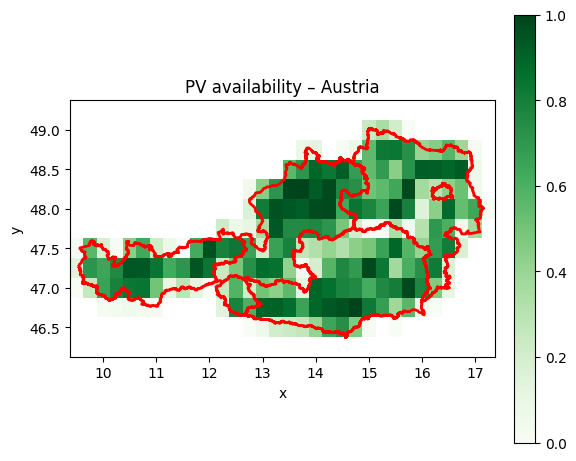

In [11]:
import matplotlib.pyplot as plt

A_country = A_pv.max(dim="region_5").where(A_pv.max(dim="region_5") > 0)

fig, ax = plt.subplots(figsize=(6, 6))

plot = A_country.plot(ax=ax,cmap="Greens",vmin=0,vmax=1,add_colorbar=False)

cbar = fig.colorbar(
    plot,
    ax=ax,
    fraction=0.046,   
    pad=0.04         
)

# Landesgrenze
regions_5.geometry.boundary.plot(
    ax=ax,
    color="red",
    linewidth=2
)

ax.set_title("PV availability – Austria")
plt.show()


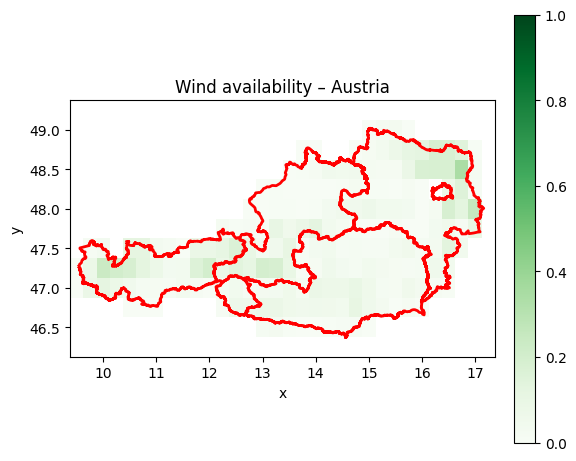

In [12]:
A_country = A_w.max(dim="region_5").where(A_w.max(dim="region_5") > 0)

fig, ax = plt.subplots(figsize=(6, 6))

plot = A_country.plot(ax=ax,cmap="Greens",vmin=0,vmax=1,add_colorbar=False)

cbar = fig.colorbar(
    plot,
    ax=ax,
    fraction=0.046,   
    pad=0.04         
)

# Landesgrenze
regions_5.geometry.boundary.plot(
    ax=ax,
    color="red",
    linewidth=2
)

ax.set_title("Wind availability – Austria")
plt.show()

In [13]:
print("Regions CRS:", regions.crs)
print("Cutout grid CRS:", cutout.grid.crs)


Regions CRS: EPSG:4326
Cutout grid CRS: EPSG:4326


In [14]:
import xarray as xr
import atlite

# 1) Zellflächen des Cutout-Grids (km²)
area_km2 = cutout.grid.to_crs(3035).area / 1e6
area_km2 = xr.DataArray(area_km2.values, dims=("spatial",))

# 2) Kapazitätsmatrix aus Availability * Fläche * Dichte
density = 3.0  # MW / km²

M_pv = A_pv.stack(spatial=["y", "x"]) * area_km2 * density  # (region_5, spatial) in MW
M_w = A_w.stack(spatial=["y", "x"]) * area_km2 * density  # (region_5, spatial) in MW

# 3) PV-Erzeugung und installierte Leistung je Region (atlite)
pv_gen, pv_cap = cutout.pv(
    matrix=M_pv,
    index=regions_5.index,
    panel=atlite.solarpanels.CdTe,
    orientation="latitude_optimal",
    return_capacity=True,
)

#4 wind
wind_gen, wind_cap = cutout.wind(
    matrix=M_w,
    index=regions_5.index,
    turbine=atlite.windturbines.Vestas_V112_3MW,
    return_capacity=True,
)

# 5) Capacity factor time series
pv_cf = pv_gen / pv_cap
pv_cf_df=pv_cf.to_pandas()
print(pv_cf_df)

wind_cf=wind_gen/wind_cap
wind_cf_df=wind_cf.to_pandas()
print(wind_cf_df)

region_5             Kärnten/Steiermark  Niederösterreich/Burgenland  \
time                                                                   
2019-01-01 00:00:00                 0.0                          0.0   
2019-01-01 01:00:00                 0.0                          0.0   
2019-01-01 02:00:00                 0.0                          0.0   
2019-01-01 03:00:00                 0.0                          0.0   
2019-01-01 04:00:00                 0.0                          0.0   
...                                 ...                          ...   
2020-01-01 19:00:00                 0.0                          0.0   
2020-01-01 20:00:00                 0.0                          0.0   
2020-01-01 21:00:00                 0.0                          0.0   
2020-01-01 22:00:00                 0.0                          0.0   
2020-01-01 23:00:00                 0.0                          0.0   

region_5             Oberösterreich/Salzburg  Tirol/Vorarlberg 

/opt/miniconda3/envs/global_py/lib/python3.11/site-packages/atlite/resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)


In [15]:
avg_PV_cf=pv_cf_df.mean()
avg_PV_cf

region_5
Kärnten/Steiermark             0.152896
Niederösterreich/Burgenland    0.150924
Oberösterreich/Salzburg        0.153399
Tirol/Vorarlberg               0.163513
Wien                           0.151308
dtype: float64

In [16]:
avg_Wind_CF=wind_cf_df.mean()
avg_Wind_CF

region_5
Kärnten/Steiermark             0.023213
Niederösterreich/Burgenland    0.223142
Oberösterreich/Salzburg        0.035941
Tirol/Vorarlberg               0.012133
Wien                           0.280069
dtype: float64